In [ ]:
%pylab inline
!pip install -q gdown httpimport
!pip install wandb --upgrade
!pip install fastai --upgrade
!pip install torch==1.9.0

In [ ]:
import wandb
wandb.login()

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import MultivariateNormal, Uniform
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose
from torchvision import transforms
from torchvision import datasets
import collections
from PIL import Image

device = 'cuda'

# Utils

## config

In [ ]:
config = dict(
    epochs=100,
    batch_size=64,
    img_size=256,
    G_lr=0.001,
    C_lr=0.0001,
    lambda_=1.,
    wass_alpha = 1.,
    log_every=50,
    data_dir='../input',
    dataset='landscapes',
    dataset_in_rgb = True,
    architecture='GAN',
    device='cuda',
    )

## data loader
with simple data augmentation

In [ ]:
from skimage import color

def transform_img(x, imsize, lab=True):
    pre_trans = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize([int(imsize*1.2), int(imsize*1.2)]),
                transforms.RandomAffine(degrees=25, scale=(1.,1.1)),
                transforms.CenterCrop(imsize),
                transforms.Resize([imsize, imsize]),
                transforms.RandomHorizontalFlip(),
            ])
    x = pre_trans(x)
    if lab:
        x = color.rgb2lab(x.permute(1,2,0))
        x = transforms.ToTensor()(x)
    return x

def get_data(imsize = 256, batch_size = 64, data_dir = None, lab=True):
    # ImageFloder with root directory and defined transformation methods for batch as well as data augmentation
    data = datasets.ImageFolder(root=data_dir, transform = lambda x: transform_img(x, imsize, lab=lab))
    data_loader = DataLoader(dataset=data, batch_size=batch_size, shuffle=True, num_workers=1)
 
    return data_loader

def get_img(path, imsize=256,lab=True):
    im = Image.open(path)
    return transform_img(im, imsize,lab=lab)

## rgb <-> lab
differentiable convertion between formats in pytorch

In [ ]:
'''
NOW WORKS FOR BATCHES!
adapted code from 
https://github.com/smartcameras/EdgeFool/blob/master/Train/rgb_lab_formulation_pytorch.py
'''

def rgb_to_lab(srgb):
    
    srgb = srgb.permute(0, 2, 3, 1).cuda()
    srgb_pixels = torch.reshape(srgb, [srgb.size(0), -1, 3])

    linear_mask = (srgb_pixels <= 0.04045).type(torch.FloatTensor).cuda()
    exponential_mask = (srgb_pixels > 0.04045).type(torch.FloatTensor).cuda()
    rgb_pixels = (srgb_pixels / 12.92 * linear_mask) + (((srgb_pixels + 0.055) / 1.055) ** 2.4) * exponential_mask

    rgb_to_xyz = torch.tensor([
                #    X        Y          Z
                [0.412453, 0.212671, 0.019334], # R
                [0.357580, 0.715160, 0.119193], # G
                [0.180423, 0.072169, 0.950227], # B
            ]).type(torch.FloatTensor).cuda()

    xyz_pixels = torch.matmul(rgb_pixels, rgb_to_xyz)


    # XYZ to Lab
    xyz_normalized_pixels = torch.mul(xyz_pixels, torch.tensor([1/0.950456, 1.0, 1/1.088754]).type(torch.FloatTensor).cuda())

    epsilon = 6.0/29.0

    linear_mask = (xyz_normalized_pixels <= (epsilon**3)).type(torch.FloatTensor).cuda()

    exponential_mask = (xyz_normalized_pixels > (epsilon**3)).type(torch.FloatTensor).cuda()

    fxfyfz_pixels = (xyz_normalized_pixels / (3 * epsilon**2) + 4.0/29.0) * linear_mask + ((xyz_normalized_pixels+0.000001) ** (1.0/3.0)) * exponential_mask
    # convert to lab
    fxfyfz_to_lab = torch.tensor([
        #  l       a       b
        [  0.0,  500.0,    0.0], # fx
        [116.0, -500.0,  200.0], # fy
        [  0.0,    0.0, -200.0], # fz
    ]).type(torch.FloatTensor).cuda()
    lab_pixels = torch.matmul(fxfyfz_pixels, fxfyfz_to_lab) + torch.tensor([-16.0, 0.0, 0.0]).type(torch.FloatTensor).cuda()
    #return tf.reshape(lab_pixels, tf.shape(srgb))
    return torch.reshape(lab_pixels, srgb.shape).permute(0, 3, 1, 2)

def lab_to_rgb(lab):
    lab = lab.permute(0, 2, 3, 1).cuda()
    lab_pixels = torch.reshape(lab, [lab.size(0), -1, 3])
    # convert to fxfyfz
    lab_to_fxfyfz = torch.tensor([
        #   fx      fy        fz
        [1/116.0, 1/116.0,  1/116.0], # l
        [1/500.0,     0.0,      0.0], # a
        [    0.0,     0.0, -1/200.0], # b
    ]).type(torch.FloatTensor).cuda()
    fxfyfz_pixels = torch.matmul(lab_pixels + torch.tensor([16.0, 0.0, 0.0]).type(torch.FloatTensor).cuda(), lab_to_fxfyfz)

    # convert to xyz
    epsilon = 6.0/29.0
    linear_mask = (fxfyfz_pixels <= epsilon).type(torch.FloatTensor).cuda()
    exponential_mask = (fxfyfz_pixels > epsilon).type(torch.FloatTensor).cuda()


    xyz_pixels = (3 * epsilon**2 * (fxfyfz_pixels - 4/29.0)) * linear_mask + ((fxfyfz_pixels+0.000001) ** 3) * exponential_mask

    # denormalize for D65 white point
    xyz_pixels = torch.mul(xyz_pixels, torch.tensor([0.950456, 1.0, 1.088754]).type(torch.FloatTensor).cuda())


    xyz_to_rgb = torch.tensor([
        #     r           g          b
        [ 3.2404542, -0.9692660,  0.0556434], # x
        [-1.5371385,  1.8760108, -0.2040259], # y
        [-0.4985314,  0.0415560,  1.0572252], # z
    ]).type(torch.FloatTensor).cuda()

    rgb_pixels =  torch.matmul(xyz_pixels, xyz_to_rgb)
    # avoid a slightly negative number messing up the conversion
    #clip
    rgb_pixels[rgb_pixels > 1] = 1.
    rgb_pixels[rgb_pixels < 0] = 0.

    linear_mask = (rgb_pixels <= 0.0031308).type(torch.FloatTensor).cuda()
    exponential_mask = (rgb_pixels > 0.0031308).type(torch.FloatTensor).cuda()
    srgb_pixels = (rgb_pixels * 12.92 * linear_mask) + (((rgb_pixels+0.000001) ** (1/2.4) * 1.055) - 0.055) * exponential_mask

    return torch.reshape(srgb_pixels, lab.shape).permute(0, 3, 1, 2)

## show img

In [ ]:
def show_img_gen(img, img_col = None, show= True):
    with torch.no_grad():
        if img_col is not None:
            img = torch.cat([img.cpu(), img_col.cpu()], 0)
        img = color.lab2rgb(img.cpu().permute(1,2,0))
        if show:
            plt.imshow(img)
            plt.show()
        else:
            return img

# Net architecture

## UNet Block

In [ ]:
'''
Net architecture from
https://towardsdatascience.com/colorizing-black-white-images-with-u-net-and-conditional-gan-a-tutorial-81b2df111cd8
same story for Critic
'''

class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
#             up = [uprelu, upconv, nn.Tanh()]
            up = [uprelu, upconv] #remove tanh - accelerates learning!
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)


## Generator

In [ ]:
class TheGenerator(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)

        for _ in range(n_down - 4):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8

        for _ in range(2):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)
    
    
    def forward(self, x):
        return self.model(x)

## Critic

In [ ]:
class Critic(nn.Module):
    def __init__(self, input_c=3, nf=64, n_down=3):
        super(Critic, self).__init__()
        model = [self.get_layers(input_c, nf, norm=False)]
        model += [self.get_layers(nf * 2 ** i, nf * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(nf * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        model += [nn.Sigmoid()] # seems reasonable
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

## losses

In [ ]:
def generator_loss(DG, eps=1e-6):
  # Define Generator loss. Use eps for numerical stability of log.
    return - (DG + eps).log().mean()

def img_l1_loss(img_fake, img_real):
    return nn.L1Loss()(img_fake, img_real)
    
def critic_loss(DR, DG, eps=1e-6):
    # Define Discriminator loss. Use eps for numerical stability of log.
    return - (DR + eps).log().mean() - (1- DG + eps).log().mean()

### wass l2 loss

An interesting one. We wanted to extract style of an image using pretrained vgg network (as we did in Assignment 3) but instead of using the mean squared network between styles of two pictures we wanted to do something more clever. We apply an Earth Mover Distance/ Wasserstein Distance assuming our features have gaussian distribution (we 'sample' across channel dimension, independently for each element of the batch). Interestingly it is stated that the required computation is not too heavy (arguably).

The math is here 
https://github.com/VinceMarron/style_transfer/blob/master/style-transfer-theory.pdf

In [ ]:
import torchvision.models as models
import torch
import torch.linalg 

class WassFeatureLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg_features = models.vgg19(True).features.cuda().eval()
        self.RGB_MEANS = torch.FloatTensor([0.485, 0.456, 0.406])[None, :, None, None].cuda()
        self.RGB_STDS = torch.FloatTensor([0.229, 0.224, 0.225])[None, :, None, None].cuda()

    def _get_features(self, x, clone=False):
        x = (x - torch.autograd.Variable(self.RGB_MEANS)) / torch.autograd.Variable(self.RGB_STDS)
        x = self.vgg_features(x)
        x = x.view(x.size(0), x.size(1), -1)
        return x.clone() if clone else x

    def _calc_2_moments(self, tensor): #bs x chans x n -> bs x chans x chans
        n = tensor.shape[2]
        mu = tensor.mean(2)
        tensor = (tensor - mu[:, :, None])
        # Prevents nasty bug that happens very occassionally- divide by zero.  Why such things happen?
        if n == 0:
            return None, None
         # TODO: ROOM FOR IMPROVEMENDT BELOW
        cov = torch.vstack([torch.matmul(tens, tens.t()).unsqueeze(0) for tens in tensor])/ float(n)
        return mu, cov
    
    def _calc_l2wass_dist(self, mu1, cov1, mu2, cov2): # bs x chans ; bs x chans x chans
        mean_diff_squared = (mu1 - mu2).pow(2).sum(1) # bs
        bs = mu1.size(0)
        var_overlap = torch.zeros(bs, device=device)
        var_components = torch.zeros(bs, device=device)
        for i in range(bs):
            cov1_flat, cov2_flat = cov1[i], cov2[i]
            eigvals1, eigvects1 = torch.linalg.eigh(cov1_flat)
            eigroot_mat1 = torch.diag(torch.sqrt(eigvals1.clamp(min=0)))
            root_cov1 = torch.mm(torch.mm(eigvects1, eigroot_mat1), eigvects1.t())
            cov_prod = torch.mm(torch.mm(root_cov1, cov2_flat), root_cov1)
            
            tr_cov2 = torch.linalg.eigh(cov2)[0].clamp(min=1e-5).sum()
            tr_cov1 = eigvals1.clamp(min=1e-5).sum()
            var_components[i] = tr_cov1 + tr_cov2
            var_overlap[i] = torch.sqrt(
                torch.linalg.eigh(cov_prod)[0].clamp(min=0) + 1e-8
            ).sum()

        return  (mean_diff_squared + var_components - 2 * var_overlap).sqrt()
    
    def forward(self, x, y):
        x_feat = self._get_features(x.to(device))
        y_feat = self._get_features(y.to(device), clone=True)
        
        x_mu, x_cov = self._calc_2_moments(x_feat)
        y_mu, y_cov = self._calc_2_moments(y_feat)

        dist = self._calc_l2wass_dist(x_mu, x_cov, y_mu, y_cov)

        return dist.mean()


# Let's go

## init

In [ ]:
def make(config):
    img_dl = get_data(config.img_size, batch_size=config.batch_size, data_dir=config.data_dir, lab= not config.dataset_in_rgb)

    G = TheGenerator().to(config.device)
    C = Critic().to(config.device)

    G_optimizer = optim.Adam(G.parameters(), lr=config.G_lr)
    C_optimizer = optim.Adam(C.parameters(), lr=config.C_lr) 

    return G, C, G_optimizer, C_optimizer, img_dl

## training loop
copy-pasted from Assignment 5

In [ ]:
def train(G, C, img_dl, G_optimizer, C_optimizer, config):
    wandb.watch(G, log="all", log_freq=5)
    wandb.watch(C, log="all", log_freq=5)
    wass_l2_dist = WassFeatureLoss()
    G_loss = 0.0
    C_loss = 0.0  
    for epoch in range(config.epochs):
        start_time = time.time()

        for i, (img_real_rgb, _) in enumerate(img_dl):
            #pictures are ALWAYS in shape (bs, 3, ims, ims)
            img_real_lab = rgb_to_lab(img_real_rgb).to(config.device).requires_grad_()
            img_bw = img_real_lab[:,0,:,:].unsqueeze(1)

            img_fake_lab = torch.cat([img_bw, G(img_bw)], 1)  
            img_fake_rgb = lab_to_rgb(img_fake_lab.clamp(min=-110.,max=110.))
            
            img_fake_detached = img_fake_lab.detach()
            
            if True: #i % config.log_every == 0 and i>0:
                G.eval()
                with torch.no_grad():
                    print(
                      f"Epoch: {epoch} i: {i} Generator loss: {G_loss :.4f} Critic loss: {C_loss:.4f}"
                    )
                    fig = plt.figure(figsize=(20, 8))
                    for j in range(5):
                        fig.add_subplot(2, 5, 1 + j)
                        plt.axis('off')
                        plt.imshow(show_img_gen(img_fake_lab[j],show = False))
                    for j in range(5):
                        fig.add_subplot(2, 5, 6 + j)
                        plt.axis('off')
                        plt.imshow(show_img_gen(img_real_lab[j],show = False))  
                    plt.show()
                    wandb.log({
                        'G_loss': G_loss,
                        'C_loss': C_loss,
                        'generated_imgs': [wandb.Image(color.lab2rgb(img.cpu().permute(1,2,0))) for img in img_fake_detached[:5]],
                        'original_imgs': [wandb.Image(color.lab2rgb(img.cpu().permute(1,2,0))) for img in img_real_lab[:5]],
                    })

                G_loss = 0.0
                C_loss = 0.0
                G.train()
            
            wass = wass_l2_dist(img_fake_rgb, img_real_rgb)
            l1 = img_l1_loss(img_fake_lab, img_real_lab)
            
            G_loss = generator_loss(C(img_fake_lab)) \
                + config.lambda_ *  l1 \
                + config.wass_alpha * wass 

            G_optimizer.zero_grad()
            G_loss.backward()
            torch.nn.utils.clip_grad_norm_(G.parameters(), 1e4)
            G_optimizer.step()
            
            C_loss = critic_loss(C(img_real_lab), C(img_fake_detached))
    
            C_optimizer.zero_grad()
            C_loss.backward()
            C_optimizer.step()

            G_loss += G_loss.item() 
            C_loss += C_loss.item()

        delta = int(time.time() - start_time)
        print(f"Finished epoch {epoch} in {delta//60}min {delta % 60}s")
        if epoch % 10 == 0 and epoch > 0:
            print(f"saving models..")
            save_models(G, C, G_path=f'generator_{epoch}.pth', C_path=f'critic_{epoch}.pth')

## W&B requirement 

We use an interesting tool helping with data visualisation and compute management called Weights & Biases.
More here:
https://wandb.ai/

In [ ]:
def model_pipeline(params, saved_G=None, saved_C=None):
    with wandb.init(entity="colorify", project="colorify", config=params):
        config = wandb.config
        G, C, G_optimizer, C_optimizer, img_dl = make(config)
        if saved_G is not None:
            G = saved_G
        if saved_C is not None:
            C = saved_C
        train(G, C, img_dl, G_optimizer, C_optimizer, config)
        # imgs = get_imgs(G)

        torch.onnx.export(G, next(iter(img_dl))[0][:,0,None].to(config.device).float(), "G.onnx")
        wandb.save("G.onnx")

        torch.onnx.export(C, next(iter(img_dl))[0].to(config.device).float(), "C.onnx")
        wandb.save("C.onnx")

    return G, C

## save/load model

In [ ]:
def save_models(G, C, G_path='generator.pth', C_path='critic.pth'):
    torch.save(G.state_dict(), G_path)
    torch.save(C.state_dict(), C_path)

def load_models(G, C, G_path='generator.pth', C_path='critic.pth'):
    G.load_state_dict(torch.load(G_path))
    C.load_state_dict(torch.load(C_path))

In [ ]:
G = TheGenerator().to(device)
C = Critic().to(device) 
load_models(G, C, G_path='./checkpoint4/generator_210_aug_3.pth', C_path='./checkpoint4/critic_210_aug_3.pth')

## start!

In [ ]:
G, C = model_pipeline(config)

# Results


## show results

In [ ]:
def show_results(net_names, dataset_name, num_images):
    G = TheGenerator().to(device)
    data_path = f"../input/validate/validate/{dataset_name}"
    data_loader = get_data(256, batch_size=num_images, data_dir=data_path, lab=False)
    img_real_rgb, _ = next(iter(data_loader))
    n = len(net_names)
    fig = plt.figure(figsize=(4*num_images, 4*(n+1)))
    with torch.no_grad():
        for i, net_name in enumerate(net_names):
            G_path = f"../input/all-checkpoints/generator_{net_name}.pth"
            G.load_state_dict(torch.load(G_path))
            G.eval()
            img_real_lab = rgb_to_lab(img_real_rgb).to(device)
            img_bw = img_real_lab[:,0,:,:].unsqueeze(1)
            img_fake_lab = torch.cat([img_bw, G(img_bw)], 1)
            img_fake_rgb = lab_to_rgb(img_fake_lab)
        
            print(f"Generator {net_name} results")
            
            for j in range(num_images):
                fig.add_subplot(n+1, num_images, 1 + num_images*i + j)
                plt.axis('off')
                plt.imshow(img_fake_rgb[j].cpu().permute(1,2,0))
                     
    for j in range(num_images):
        fig.add_subplot(n+1, num_images, num_images*n + 1 + j)
        plt.axis('off')
        plt.imshow(img_real_rgb[j].cpu().permute(1,2,0))  
    plt.show()

In [ ]:
def color_imgs(img, G):
    G.eval()
    img_real_lab = rgb_to_lab(img).to(device)
    img_bw = img_real_lab[:,0,:,:].unsqueeze(1)
    img_fake_lab = torch.cat([img_bw, G(img_bw)], 1)
    img_fake_rgb = lab_to_rgb(img_fake_lab)
    return img_fake_rgb.detach()

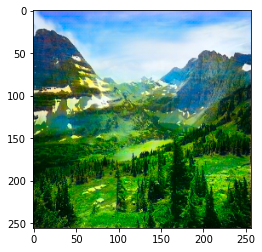

In [ ]:
net_name = "290_v2_aug_3"
G = TheGenerator().to(device)
G.load_state_dict(torch.load(f"../input/all-checkpoints/generator_{net_name}.pth"))
img = get_img("../input/luululu/glacier.jpg",lab=False)[None]
plt.imshow(color_imgs(img,G)[0].cpu().permute(1,2,0))

## pretty images


Generator 50 results
Generator 200_aug_3 results
Generator 290_v2_aug_3 results


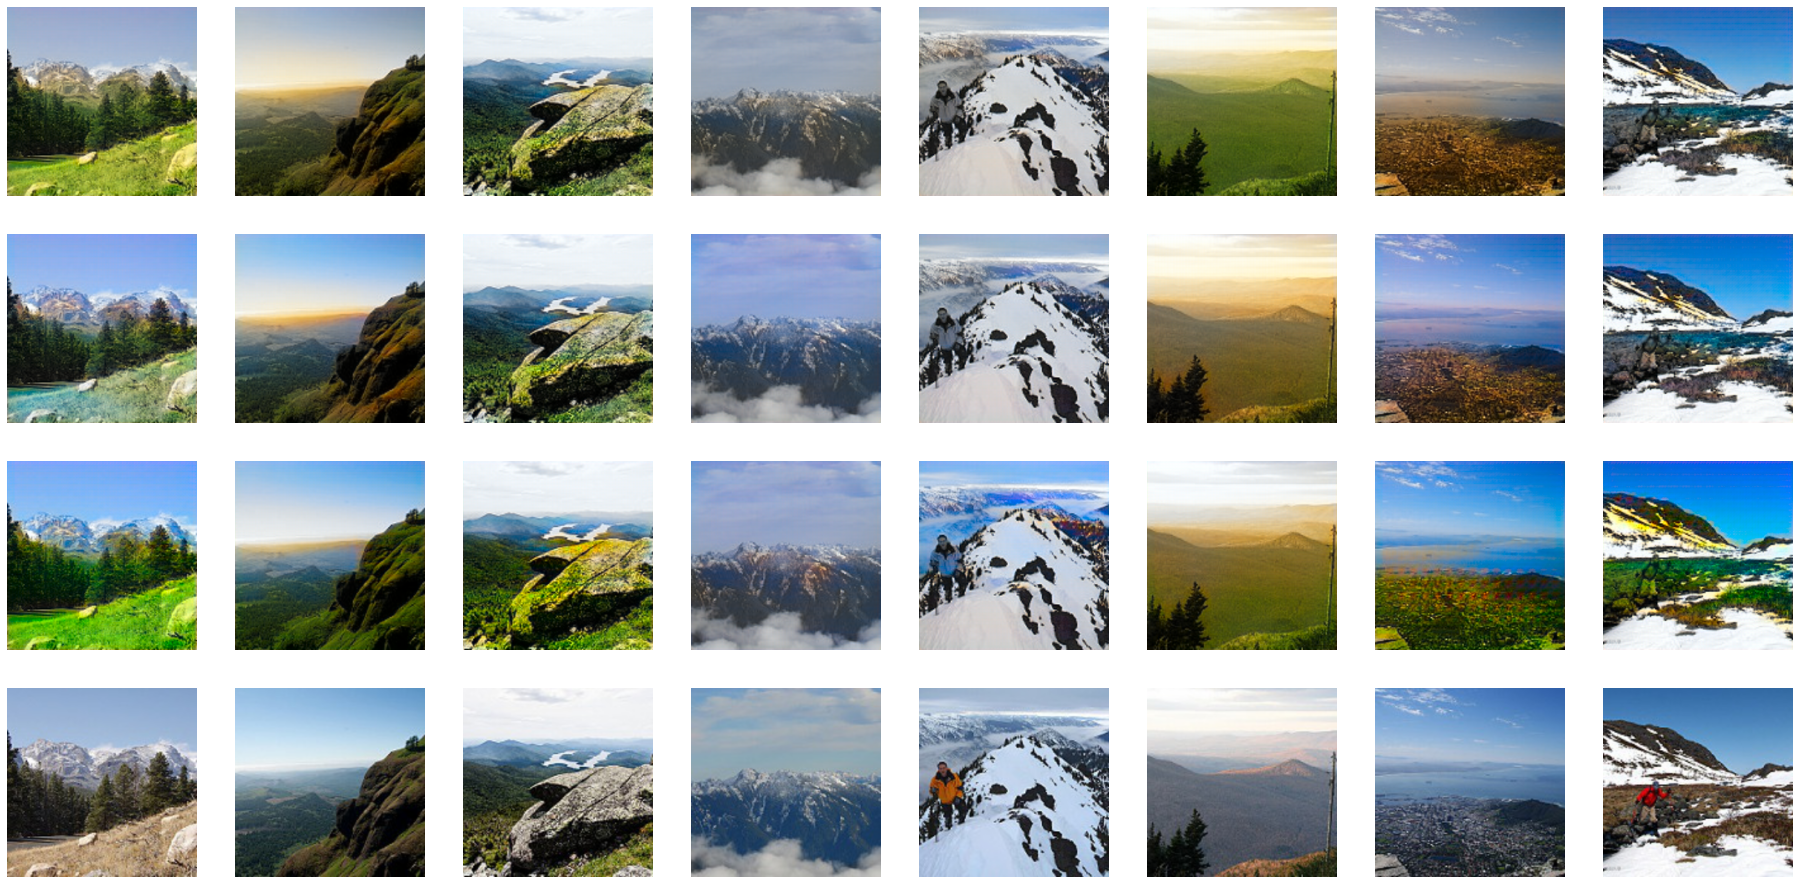

In [ ]:
# net_names = ['50','90','100_aug','160_aug_2','200_aug_3','250_v2_aug_3','250_v2_aug_3_vgg','290_v2_aug_3']
net_names = ['50','200_aug_3', '290_v2_aug_3']
show_results(net_names, 'mountain', 8)


    